# Librerias

In [12]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Token

In [7]:
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["axes.grid"] = True

BANXICO_TOKEN = "caa9ce3af73a7040c54f64908e2af98fd965b7c816828c6d90836ff2dd38a9d2"

# === 3. Definir serie y rango de fechas ===
serie_id = "SF43783"   # TIIE 28 días
fecha_ini = "2000-01-01"   # desde el año 2000
fecha_fin = pd.Timestamp.today().strftime("%Y-%m-%d")

# === 4. Descargar datos desde la API ===
url = f"https://www.banxico.org.mx/SieAPIRest/service/v1/series/{serie_id}/datos/{fecha_ini}/{fecha_fin}"
headers = {"Bmx-Token": BANXICO_TOKEN}
response = requests.get(url, headers=headers)

if response.status_code != 200:
    raise ValueError(f"Error en la API: {response.status_code}, {response.text}")

data = response.json()
datos = data["bmx"]["series"][0]["datos"]

# === 5. Crear DataFrame ===
df = pd.DataFrame(datos)
df["fecha"] = pd.to_datetime(df["fecha"], format="%d/%m/%Y", dayfirst=True)
df["dato"] = pd.to_numeric(df["dato"].replace({"N/E": pd.NA}), errors="coerce")

# Indexamos por fecha y ordenamos
df = df.set_index("fecha").sort_index()

# === 6. Verificación ===
print(df.info())
print(df.head())
print(df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6473 entries, 2000-01-03 to 2025-09-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   dato    6473 non-null   float64
dtypes: float64(1)
memory usage: 101.1 KB
None
              dato
fecha             
2000-01-03  18.760
2000-01-04  18.560
2000-01-05  18.615
2000-01-06  18.655
2000-01-07  18.675
              dato
fecha             
2025-09-11  8.0126
2025-09-12  8.0126
2025-09-15  8.0126
2025-09-17  8.0226
2025-09-18  8.0226


In [8]:
# Conteo total de nulos en la columna
print("Total de valores nulos:", df["dato"].isna().sum())

# Conteo de nulos por año (para ver en qué periodos están concentrados)
print("\nValores nulos por año:")
print(df["dato"].isna().groupby(df.index.year).sum())

Total de valores nulos: 0

Valores nulos por año:
fecha
2000    0
2001    0
2002    0
2003    0
2004    0
2005    0
2006    0
2007    0
2008    0
2009    0
2010    0
2011    0
2012    0
2013    0
2014    0
2015    0
2016    0
2017    0
2018    0
2019    0
2020    0
2021    0
2022    0
2023    0
2024    0
2025    0
Name: dato, dtype: int64


In [9]:
df

,dato
fecha,
2000-01-03,18.7600
2000-01-04,18.5600
2000-01-05,18.6150
2000-01-06,18.6550
2000-01-07,18.6750
...,...
2025-09-11,8.0126
2025-09-12,8.0126
2025-09-15,8.0126


### No hay datos nulos ni fines de semana inventados

## reporte simple de rango temporal y valores máximos/mínimos

Fecha inicial: 2000-01-03 00:00:00
Fecha final: 2025-09-18 00:00:00
Número total de observaciones: 6473

Resumen estadístico:
count    6473.000000
mean        7.447035
std         3.246357
min         3.274100
25%         4.840000
50%         7.373000
75%         8.720000
max        19.450000
Name: dato, dtype: float64

Valor máximo: 19.45 el 2000-02-02
Valor mínimo: 3.27 el 2014-09-29


<Axes: title={'center': 'TIIE 28 días - Serie completa'}, xlabel='fecha'>

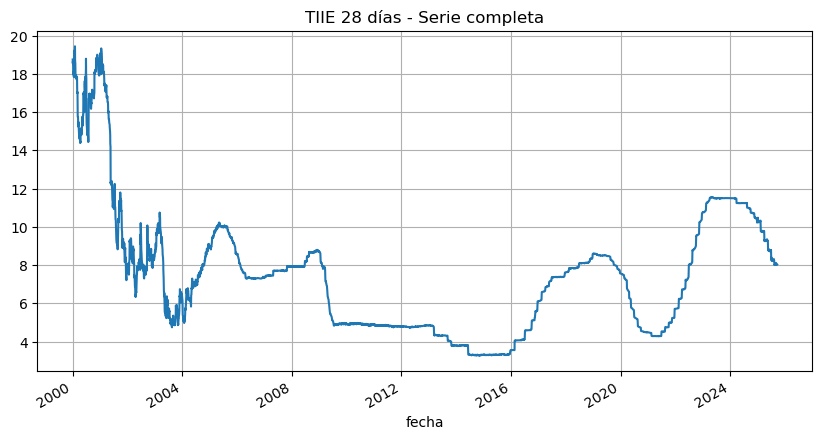

In [10]:
# === Rango temporal ===
print("Fecha inicial:", df.index.min())
print("Fecha final:", df.index.max())
print("Número total de observaciones:", len(df))

# === Valores extremos ===
print("\nResumen estadístico:")
print(df["dato"].describe())

# === Valores máximos y mínimos concretos ===
max_date = df["dato"].idxmax()
min_date = df["dato"].idxmin()
print(f"\nValor máximo: {df['dato'].max():.2f} el {max_date.date()}")
print(f"Valor mínimo: {df['dato'].min():.2f} el {min_date.date()}")

# === Gráfica rápida de toda la serie ===
df["dato"].plot(title="TIIE 28 días - Serie completa")


### Los valores de los primeros años (2000–2003) son bastante más altos (≈ 15–19%) que el resto de la historia reciente.

### A partir de 2010 en adelante, la TIIE se mueve en un rango más estable (≈ 3–12%), que es lo más relevante para el presente.

### Recorta la serie del 2010 en adelante para:

### Evitar los valores extremos de los primeros años que pueden sesgar la varianza y dificultar la estacionariedad.

### Además esos datos viejos probablemente no sean tan representativos de la política monetaria reciente.

Nuevo rango temporal:
Fecha inicial: 2010-01-04 00:00:00
Fecha final: 2025-09-18 00:00:00
Número de observaciones: 3953


<Axes: title={'center': 'TIIE 28 días desde 2010'}, xlabel='fecha'>

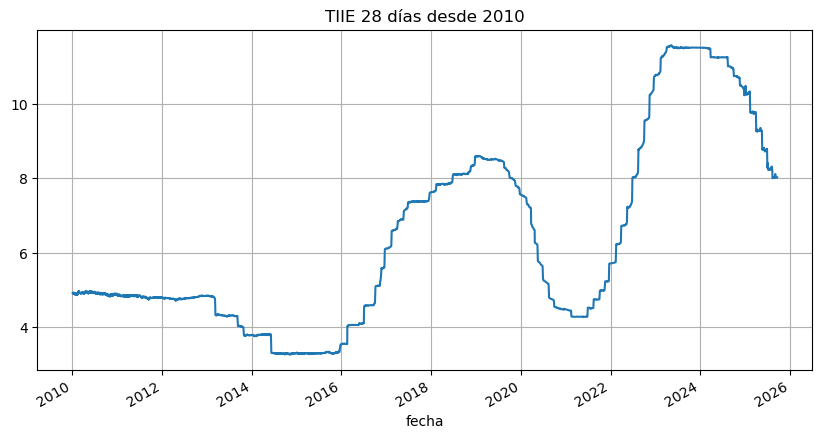

In [11]:
# Filtrar desde 2010
df_recorte = df.loc["2010-01-01":].copy()

print("Nuevo rango temporal:")
print("Fecha inicial:", df_recorte.index.min())
print("Fecha final:", df_recorte.index.max())
print("Número de observaciones:", len(df_recorte))

# Gráfica
df_recorte["dato"].plot(title="TIIE 28 días desde 2010")


### Entre 2010–2016 la TIIE estuvo en un rango bajo (≈ 3–5%).

### De 2016 a 2019 hubo una subida fuerte hasta ≈ 8.5%.

### Luego bajó con la pandemia (2020–2021).

### A partir de 2022 volvió a subir hasta ≈ 11.5% y ahora está en descenso en 2025.

### Esto es consistente con la política monetaria reciente de Banxico.

# EDA

In [13]:
# 1. Estadísticos básicos

print("Resumen estadístico:\n", df_recorte["dato"].describe())
print("\nValor máximo:", df_recorte["dato"].max(), "el", df_recorte["dato"].idxmax().date())
print("Valor mínimo:", df_recorte["dato"].min(), "el", df_recorte["dato"].idxmin().date())

Resumen estadístico:
 count    3953.000000
mean        6.405135
std         2.563602
min         3.274100
25%         4.502500
50%         4.963800
75%         8.120000
max        11.566900
Name: dato, dtype: float64

Valor máximo: 11.5669 el 2023-05-05
Valor mínimo: 3.2741 el 2014-09-29


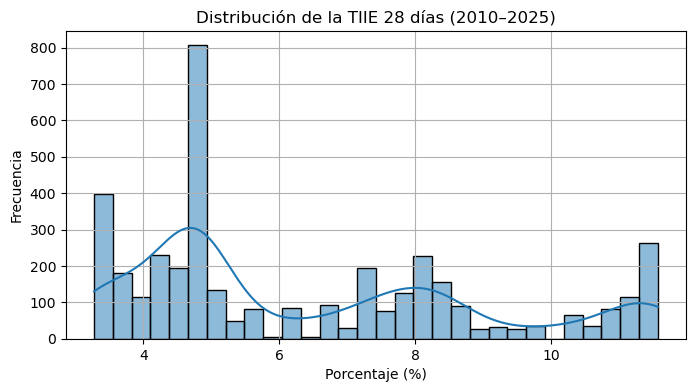

In [14]:
# 2. Histograma

plt.figure(figsize=(8,4))
sns.histplot(df_recorte["dato"], bins=30, kde=True)
plt.title("Distribución de la TIIE 28 días (2010–2025)")
plt.xlabel("Porcentaje (%)")
plt.ylabel("Frecuencia")
plt.show()

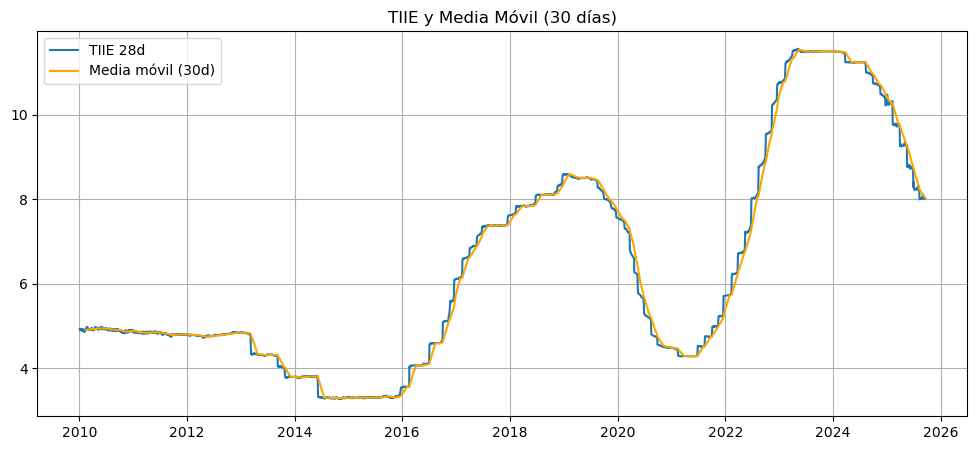

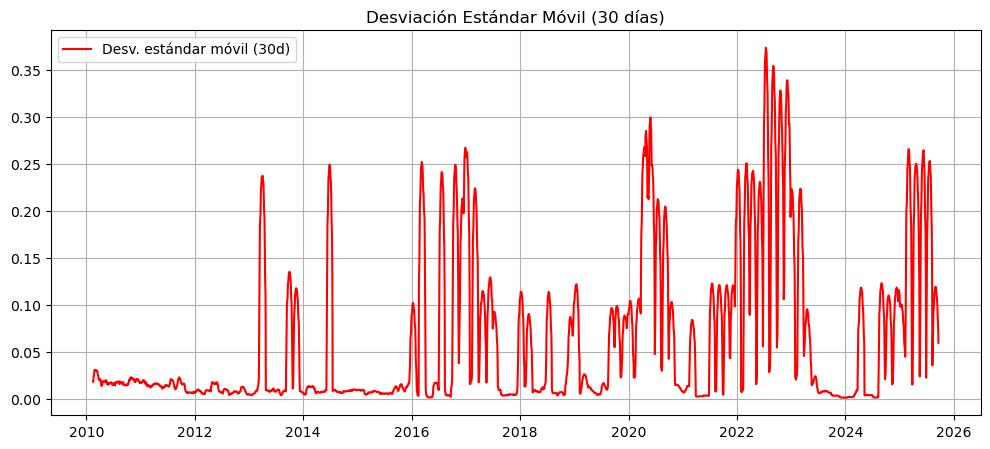

In [18]:
# 3. Media y desviación estándar móviles

rolling_mean = df_recorte["dato"].rolling(window=30).mean()
rolling_std = df_recorte["dato"].rolling(window=30).std()

# Media móvil junto con la serie
plt.figure(figsize=(12,5))
plt.plot(df_recorte["dato"], label="TIIE 28d")
plt.plot(rolling_mean, label="Media móvil (30d)", color="orange")
plt.title("TIIE y Media Móvil (30 días)")
plt.legend()
plt.show()

# Desviación estándar móvil sola
plt.figure(figsize=(12,5))
plt.plot(rolling_std, label="Desv. estándar móvil (30d)", color="red")
plt.title("Desviación Estándar Móvil (30 días)")
plt.legend()
plt.show()


In [16]:
# 4. Pruebas de estacionariedad

print("\n=== Prueba ADF ===")
adf_result = adfuller(df_recorte["dato"].dropna())
print("Estadístico ADF:", adf_result[0])
print("p-value:", adf_result[1])
print("Valores críticos:", adf_result[4])

print("\n=== Prueba KPSS ===")
kpss_result = kpss(df_recorte["dato"].dropna(), regression="c")
print("Estadístico KPSS:", kpss_result[0])
print("p-value:", kpss_result[1])
print("Valores críticos:", kpss_result[3])


=== Prueba ADF ===
Estadístico ADF: -0.9859775017609876
p-value: 0.7583442657569961
Valores críticos: {'1%': -3.4320184306790407, '5%': -2.862277221354992, '10%': -2.5671624314676738}

=== Prueba KPSS ===
Estadístico KPSS: 5.823344046403847
p-value: 0.01
Valores críticos: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\david\AppData\Local\Temp\ipykernel_23728\36711443.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df_recorte["dato"].dropna(), regression="c")


<Figure size 1000x600 with 0 Axes>

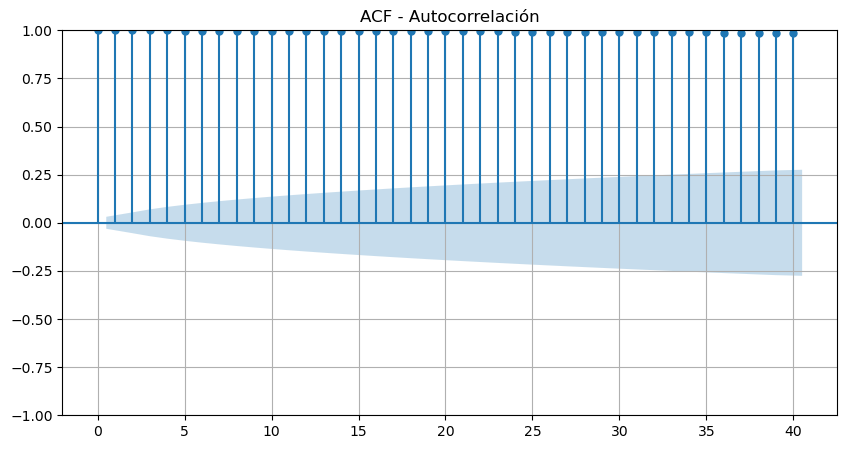

<Figure size 1000x600 with 0 Axes>

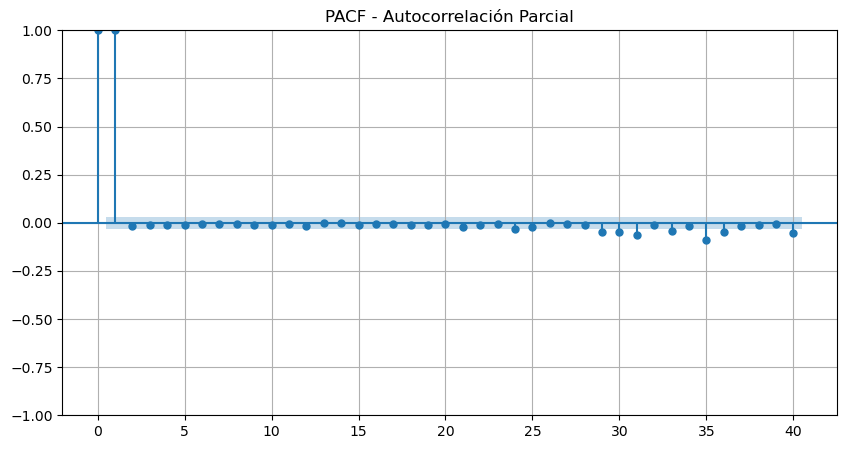

In [19]:
# 5. ACF y PACF

plt.figure(figsize=(10,6))
plot_acf(df_recorte["dato"].dropna(), lags=40)
plt.title("ACF - Autocorrelación")
plt.show()

plt.figure(figsize=(10,6))
plot_pacf(df_recorte["dato"].dropna(), lags=40)
plt.title("PACF - Autocorrelación Parcial")
plt.show()